# OASIS INFOBYTE DATA SCIENCE INTERNSHIP, DECEMBER 2023 - JANUARY 2024

## BATCH December-P1

### PROBLEM STATEMENT - EMAIL SPAM DETECTION WITH MACHINE LEARNING (TASK 4)

We’ve all been the recipients of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic messages, scams, or most dangerously, phishing content. In this Project, use Python to build an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam. Let’s get started!

DOWNLOAD DATASET FROM HERE - https://www.kaggle.com%2Fdatasets%2Fuciml%2Fsms-spam-collection-dataset&design=DAFSZMvBiCI&accessRole=viewer&linkSource=document

### SOLUTION

### AUTHOR - ARITRA BAG

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


#### IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import string
import pickle
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud

In [4]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
#importing stopwords list
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### IMPORTING THE DATASET

In [6]:
raw_dataset = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', header = 0, encoding = 'Latin', engine = 'python')
dataset = raw_dataset.iloc[:,0:2]
cols = ['is_spam', 'sms']
dataset.columns = cols
cloned_dataset = dataset
dataset.head()

,is_spam,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### EPLORATORY ANALYSIS

In [7]:
dataset.shape

(5572, 2)

In [8]:
dataset.describe()

,is_spam,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   is_spam  5572 non-null   object
 1   sms      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


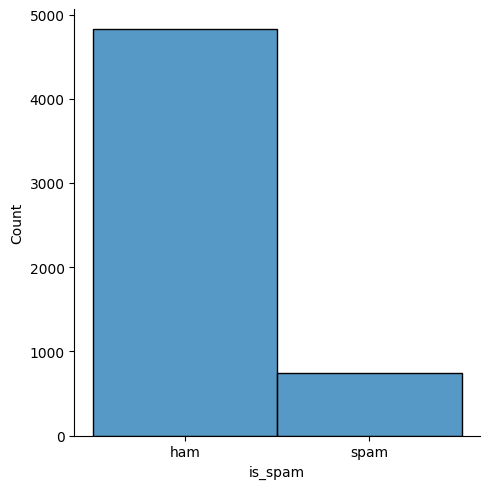

In [10]:
sns.displot(dataset['is_spam'])

#### DATA PREPROCESSING

In [11]:
working_data = dataset
working_data['is_spam'][working_data['is_spam']== 'spam'] = 1
working_data['is_spam'][working_data['is_spam']== 'ham'] = 0
working_data.head()

,is_spam,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
def preprocess_data (input):
    
    #stopword removal
    input = " ".join([word for word in str(input).split() if word not in stop_words])
    
    #converting to lower case
    input = input.lower()
    
    #url removal
    input = re.sub(r"http\S+|www\S+|https\S+","",input,flags = re.MULTILINE)
    
    #punction removal
    input = input.translate(str.maketrans("", "", string.punctuation))
                        
    #repeated character removal
    input = re.sub(r'(.)\1+', r'\1', input)
                        
    #numerical character removal
    input = re.sub('[0-9]+', '', input)
    
    #removing user@ references and #
    input = re.sub(r'\@\w+|\#w+', "", input)
                     
    #tokenization
    tokens = RegexpTokenizer(r'\w+')
    filtered_list = tokens.tokenize(input)
    
    #stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in filtered_list]
      
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos = 'a') for w in stemmed_words]
    
    #output
    return " ".join(lemma_words)

In [13]:
working_data['sms'] = working_data['sms'].apply(lambda x : preprocess_data(x))
gc.collect()

0

In [14]:
working_data.head()

,is_spam,sms
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,fre entri wkli comp win fa cup final tkt st ma...
3,0,u dun say earli hor u c alreadi say
4,0,nah i think goe usf live around though


#### PROCESSED DATA VISUALIZATION

##### SPAM

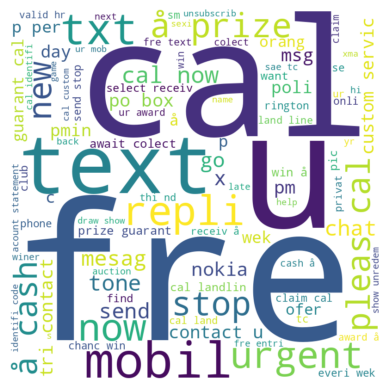

2139

In [15]:
spam = " ".join(sms for sms in working_data['sms'][working_data['is_spam']==1])
spam_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',max_words = 1000, min_font_size = 15).generate(spam)
plt.imshow(spam_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
spam_wordcloud.to_file('/kaggle/working/spam.png')
gc.collect()

##### HAM

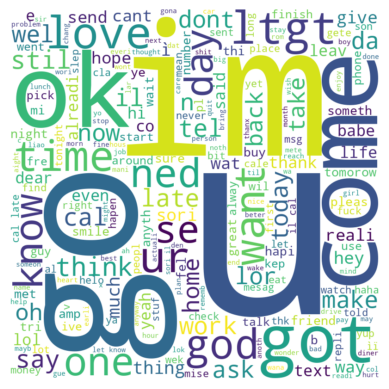

2126

In [16]:
ham = " ".join(sms for sms in working_data['sms'][working_data['is_spam']==0])
ham_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',max_words = 1000, min_font_size = 15).generate(ham)
plt.imshow(ham_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
ham_wordcloud.to_file('/kaggle/working/ham.png')
gc.collect()

#### PROCESSED SMS VECTORIZATION

In [17]:
verctorizer = TfidfVectorizer()
X = (working_data['sms'])
Y = np.array(working_data['is_spam'])
X = verctorizer.fit_transform(X)
Y = Y.astype('int')
gc.collect()

0

#### HYPERPARAMETER TUNING

In [18]:
random_state_limit = 1000
accuracies = []

for i in range(random_state_limit + 1):
    x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.15,shuffle = True, stratify = Y, random_state = i)
    x_train = x_train.toarray()
    x_test = x_test.toarray()
    test_model = LogisticRegression(solver = 'saga', max_iter = 100)
    test_model.fit(x_train, y_train)
    y_predict = test_model.predict(x_test)
    score = accuracy_score(y_test,y_predict)*100
    accuracies.append(score)
    gc.collect()
    
accuracies = np.array(accuracies)
gc.collect()

0

In [19]:
best_score = np.max(accuracies)
best_random_state = np.argmax(accuracies)
print('Best Score : ' + str(best_score))
print('Best Random State : ' + str(best_random_state))
gc.collect()

Best Score : 97.72727272727273
Best Random State : 569


0

#### TRAIN TEST SPLIT

In [20]:
x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.15,shuffle = True, stratify = Y, random_state = int(best_random_state))

In [21]:
x_train = x_train.toarray()
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [23]:
x_test = x_test.toarray()
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
y_test

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### MODEL IMPLEMENTATION

In [25]:
spam_model = LogisticRegression(solver ='saga',max_iter = 100)
spam_model.fit(x_train, y_train)

LogisticRegression(solver='saga')

#### MODEL EVALUATION

In [26]:
y_predict = spam_model.predict(x_test)

In [27]:
print('The classification test results are : \n')
print(classification_report(y_test,y_predict))
print('Confusion Matrix :')
cm=confusion_matrix(y_test,y_predict)
print(cm)
print('\n')
print('The test accuracy percentage is :')
print((accuracy_score(y_test,y_predict))*100)
print('\n')
print('The test precision percentage is :')
print((precision_score(y_test,y_predict))*100)
print('\n')
print('The test recall percentage is :')
print((recall_score(y_test,y_predict))*100)
print('\n')
print('The test f1 percentage is :')
print((f1_score(y_test,y_predict))*100)
print('\n')
print('The test ROC AUC score is :')
print(roc_auc_score(y_test,y_predict))

The classification test results are : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       0.99      0.84      0.91       112

    accuracy                           0.98       836
   macro avg       0.98      0.92      0.95       836
weighted avg       0.98      0.98      0.98       836

Confusion Matrix :
[[723   1]
 [ 18  94]]


The test accuracy percentage is :
97.72727272727273


The test precision percentage is :
98.94736842105263


The test recall percentage is :
83.92857142857143


The test f1 percentage is :
90.82125603864733


The test ROC AUC score is :
0.9189522494080506


#### WHOLE CSV IMPLEMENTATION

In [28]:
predicted_labels = ['ham','spam']
test_predicted = []
test_probability= spam_model.predict(X.toarray())
for i in range (len(test_probability)):
    test_predicted.append(predicted_labels[int(test_probability[i])])
test_labels = pd.Series((test_predicted))

In [29]:
test_dataset_final = pd.concat([cloned_dataset,test_labels],axis = 1)
test_dataset_final.columns.values[2] = 'Predicted_Labels'

In [30]:
test_dataset_final.to_csv('/kaggle/working/Processed_Test_Data.csv', index = False)